# Case 3
Cognitive Systems for Health Technology Applications   
Lassi Nurminen   
Last edited: 11.3.2018


## Objectives 
The aim of this assignment isto learn to use recurrent and 1D convolutional neural networks to
categorize medical texts

In [30]:
import os
import time
ohsumed_dir = 'ohsumed-first-20000-docs'
train_dir = os.path.join(ohsumed_dir, 'training')

labels = []
texts = []

t1 = time.time()

# Generate a list L = ['C01', 'C02, ..., 'C023']
L = ['C{:02}'.format(n) for n in range(1, 23 + 1)]
for label_type in L:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        f = open(os.path.join(dir_name, fname))
        texts.append(f.read())
        f.close()
        i = L.index(label_type)
        labels.append(i)
        
t2 = time.time()

print('Time elapsed: {:.0f} seconds.'.format((t2-t1)))

Time elapsed: 2 seconds.


## Tokenize the text of the raw data


In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 300
max_words = 20000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 30857 unique tokens


### Shape the data and labels

In [3]:
from keras.utils.np_utils import to_categorical

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
one_hot_labels = to_categorical(labels)


print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', one_hot_labels.shape)

Shape of data tensor: (10433, 300)
Shape of labels tensor: (10433, 23)


### Shuffle the data and labels

In [4]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
one_hot_labels = one_hot_labels[indices]

## Build the model


In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(L), activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 8)            160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2458624   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 23)                5911      
Total params: 2,886,935
Trainable params: 2,886,935
Non-trainable params: 0
_________________________________________________________________


## Train the model   
I tried different batch sizes and number of epochs but accuracy is still very low. 

In [28]:
import time

t1 = time.time()
history = model.fit(data, one_hot_labels,
                   epochs = 10,
                   batch_size = 50,
                   validation_split = 0.2)
t2 = time.time()
print('Elapsed time: {:.2f} seconds'.format((t2-t1)))

Train on 8346 samples, validate on 2087 samples
Epoch 1/10
8346/8346 [==============================] - 21s 3ms/step - loss: 1.1242 - acc: 0.6107 - val_loss: 10.6238 - val_acc: 0.1092
Epoch 2/10
8346/8346 [==============================] - 20s 2ms/step - loss: 1.0588 - acc: 0.6201 - val_loss: 10.2770 - val_acc: 0.0954
Epoch 3/10
8346/8346 [==============================] - 20s 2ms/step - loss: 1.0361 - acc: 0.6214 - val_loss: 10.3336 - val_acc: 0.0977
Epoch 4/10
8346/8346 [==============================] - 21s 3ms/step - loss: 1.0189 - acc: 0.6133 - val_loss: 10.4160 - val_acc: 0.0877
Epoch 5/10
8346/8346 [==============================] - 23s 3ms/step - loss: 1.0064 - acc: 0.6239 - val_loss: 10.6223 - val_acc: 0.0954
Epoch 6/10
8346/8346 [==============================] - 21s 2ms/step - loss: 1.0261 - acc: 0.6195 - val_loss: 10.3237 - val_acc: 0.0939
Epoch 7/10
8346/8346 [==============================] - 20s 2ms/step - loss: 1.0213 - acc: 0.6308 - val_loss: 10.2566 - val_acc: 0.0973


## Training results

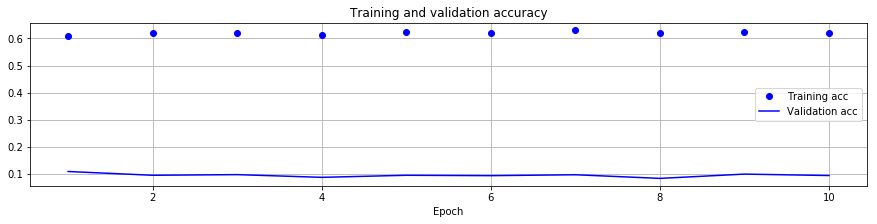

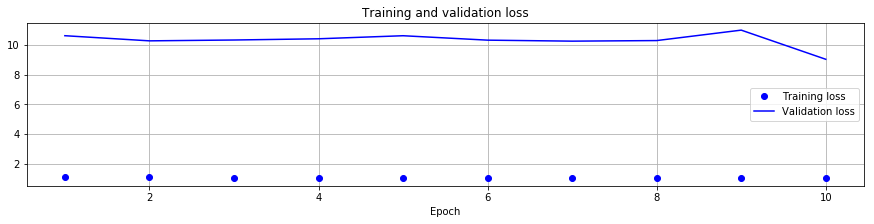

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 3))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epoch')
plt.legend()


plt.figure(figsize=(15, 3))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Metrics results

In [9]:
# Calculate the predictions
predictions = model.predict(data)
y_pred = np.argmax(predictions, axis = 1)

In [10]:
# http://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score

In [11]:
# Classification results per class
print(classification_report(labels, y_pred))

             precision    recall  f1-score   support

          0       0.59      0.42      0.49       423
          1       0.67      0.22      0.33       158
          2       0.49      0.63      0.55        65
          3       0.57      0.69      0.62      1163
          4       0.78      0.33      0.46       283
          5       0.70      0.33      0.44       588
          6       0.59      0.50      0.54       100
          7       0.58      0.40      0.47       473
          8       0.55      0.58      0.56       125
          9       0.49      0.70      0.58       621
         10       0.59      0.49      0.54       162
         11       0.55      0.53      0.54       491
         12       0.57      0.49      0.53       281
         13       0.74      0.56      0.64      1249
         14       0.45      0.56      0.50       215
         15       0.54      0.60      0.57       200
         16       0.53      0.54      0.53       295
         17       0.59      0.64      0.61   

In [12]:
# Confusion matrix
cm = confusion_matrix(labels, y_pred)
print(np.array2string(cm, max_line_width = 100))

[[ 177    3    3   11    1   11    2   10    1   26    7    8   14   10    8    3    8    4    2
    33    4    4   73]
 [   2   34    3   14    0    0    2    4    1    7    4    0    7    2    1    1    5    1    0
    46    0    1   23]
 [   2    0   41    2    0    0    0    3    0    4    1    1    2    0    0    0    0    0    0
     2    0    0    7]
 [   2    1    1  804    3    8   11   22   17   39    8   61    9   13   17    2   12   13   15
    16    3    1   85]
 [  12    0    0   13   92    2    2    3    1   30    3    4    2    3    2    6   14   11    5
     3   14    1   60]
 [  16    4    4   73    3  192    0    6    0   20    0   16    5   13   10    4    6   14    6
    11   15    5  165]
 [   0    0    0   18    0    0   50    2    2    2    1    0    0    1    1    1    4    1    0
     3    0    0   14]
 [  18    3    2   50    1    3    1  189    9   15    1    5    5   17   11    6    5    4    2
    36    8    2   80]
 [   1    0    0   14    1    0    0    

In [13]:
print(texts[indices[512]])

Primary progressive aphasia. Longitudinal course, neuropsychological profile, and language features.
 Four patients with the clinical syndrome of primary progressive aphasia and a nonfluent aphasia profile were followed up over a period of 3 to 5 years.
 Extensive neuropsychological data for three patients revealed a progressive, quantitative decline of language with relative stability of memory, visuospatial skills, and reasoning.
 Comportment and most activities of daily living were preserved even when speech was unintelligible.
 Although several aphasia types may be associated with primary progressive aphasia, a nonfluent aphasia profile and phonemic paraphasic errors are most useful in differentiating it from the much more common clinical syndrome, "probable Alzheimer's disease." The clinicopathological correlates of probable Alzheimer's disease differ from those associated with primary progressive aphasia.
 Therefore, the clinical distinction between the two syndromes may be impor

True class:  9
Predicted class: 9
Predictions per class:
[  1.09e-04   2.72e-05   1.10e-05   2.95e-02   1.13e-03   1.89e-04
   7.96e-06   9.61e-05   2.96e-05   9.52e-01   1.22e-04   5.62e-05
   2.22e-04   4.37e-03   1.69e-03   5.23e-04   8.58e-03   6.52e-05
   8.54e-05   1.90e-04   3.65e-04   3.98e-06   7.44e-04]


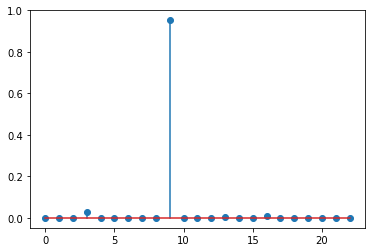

In [14]:
print('True class: ', labels[512])
print('Predicted class:', y_pred[512])
print('Predictions per class:')
print(np.array2string(predictions[512], precision = 2))

plt.stem(predictions[512])
plt.show()

In [15]:
np.__version__

'1.12.1'